# 04 — NLP: Review Sentiment Analysis
Analyze Portuguese product reviews using a pretrained multilingual model from HuggingFace,
then fine-tune it on our data.

## Step 1: Load and Preprocess Reviews

In [1]:
import pandas as pd

reviews = pd.read_csv('../data/raw/olist_order_reviews_dataset.csv')

# Keep only reviews that have text
reviews_text = reviews[reviews['review_comment_message'].notna()].copy()
reviews_text['review_comment_message'] = reviews_text['review_comment_message'].str.strip()

# Drop empty strings after stripping
reviews_text = reviews_text[reviews_text['review_comment_message'] != '']

print(f'Reviews with text: {len(reviews_text):,}')
reviews_text[['review_score', 'review_comment_message']].head(10)

c:\Users\danny\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.8.7' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\danny\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:56: UserWarning: Pandas requires version '1.4.2' or newer of 'bottleneck' (version '1.3.7' currently installed).
  from pandas.core import (


Reviews with text: 40,950


,review_score,review_comment_message
3,5,Recebi bem antes do prazo estipulado.
4,5,Parabéns lojas lannister adorei comprar pela I...
9,4,aparelho eficiente. no site a marca do aparelh...
12,4,"Mas um pouco ,travando...pelo valor ta Boa."
15,5,"Vendedor confiável, produto ok e entrega antes..."
16,2,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E..."
19,1,Péssimo
22,5,Loja nota 10
24,5,obrigado pela atençao amim dispensada
27,5,A compra foi realizada facilmente.\r\nA entreg...


## Step 2: Pretrained Sentiment Model
We use `nlptown/bert-base-multilingual-uncased-sentiment` from HuggingFace.
This model was trained on product reviews in 6 languages (including Portuguese) and predicts a star rating from 1 to 5.

The HuggingFace `pipeline` function is the simplest way to use a model — it handles tokenization, inference, and output formatting in one call.

In [2]:
from transformers import pipeline

# This downloads the model (~700MB) the first time. Cached after that.
sentiment_pipeline = pipeline(
    'sentiment-analysis',
    model='nlptown/bert-base-multilingual-uncased-sentiment',
    device=-1  # -1 = CPU
)

print('Model loaded.')

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Model loaded.


## Step 3: Test on a Few Reviews
Before running on the full dataset, test on a handful to see if predictions make sense.

In [3]:
# Test on 5 sample reviews
samples = reviews_text['review_comment_message'].head(5).tolist()

for text, result in zip(samples, sentiment_pipeline(samples, truncation=True)):
    label = result['label']
    print(f'Predicted: {label}  |  {text[:80]}')

Predicted: 3 stars  |  Recebi bem antes do prazo estipulado.
Predicted: 5 stars  |  Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns 
Predicted: 3 stars  |  aparelho eficiente. no site a marca do aparelho esta impresso como 3desinfector 
Predicted: 3 stars  |  Mas um pouco ,travando...pelo valor ta Boa.
Predicted: 4 stars  |  Vendedor confiável, produto ok e entrega antes do prazo.


## Step 4: Run Sentiment on All Reviews
Process all reviews in batches. The model returns labels like '1 star', '2 stars', etc. We extract the number.

In [4]:
# Process all reviews in batches
texts = reviews_text['review_comment_message'].tolist()

# Run inference in batches of 32 (this will take a few minutes)
results = sentiment_pipeline(texts, truncation=True, batch_size=32)

# Extract the predicted star rating (1-5) from the label
reviews_text['predicted_sentiment'] = [int(r['label'].split()[0]) for r in results]

print('Done!')
reviews_text[['review_score', 'review_comment_message', 'predicted_sentiment']].head(10)

Done!


,review_score,review_comment_message,predicted_sentiment
3,5,Recebi bem antes do prazo estipulado.,3
4,5,Parabéns lojas lannister adorei comprar pela I...,5
9,4,aparelho eficiente. no site a marca do aparelh...,3
12,4,"Mas um pouco ,travando...pelo valor ta Boa.",3
15,5,"Vendedor confiável, produto ok e entrega antes...",4
16,2,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...",1
19,1,Péssimo,1
22,5,Loja nota 10,5
24,5,obrigado pela atençao amim dispensada,1
27,5,A compra foi realizada facilmente.\r\nA entreg...,5


## Step 5: Evaluate — How Good Is the Pretrained Model?
Compare predicted sentiment to actual review_score.
They won't match perfectly (sentiment != star rating), but they should correlate.

Correlation between actual score and predicted sentiment: 0.713


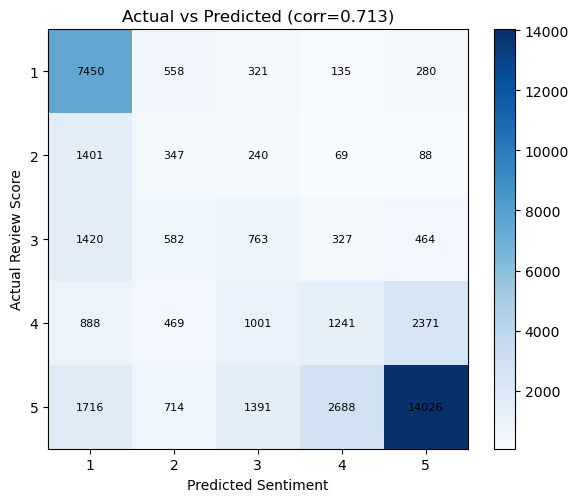

In [5]:
import matplotlib.pyplot as plt
import numpy as np

reviews_text['review_score'] = reviews_text['review_score'].astype(int)

corr = reviews_text['review_score'].corr(reviews_text['predicted_sentiment'])
print(f'Correlation between actual score and predicted sentiment: {corr:.3f}')

ct = pd.crosstab(reviews_text['review_score'], reviews_text['predicted_sentiment'],
                 rownames=['Actual Score'], colnames=['Predicted Sentiment'])

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(ct.values, cmap='Blues')
ax.set_xticks(range(len(ct.columns)))
ax.set_yticks(range(len(ct.index)))
ax.set_xticklabels(ct.columns)
ax.set_yticklabels(ct.index)
ax.set_xlabel('Predicted Sentiment')
ax.set_ylabel('Actual Review Score')
ax.set_title(f'Actual vs Predicted (corr={corr:.3f})')
for i in range(len(ct.index)):
    for j in range(len(ct.columns)):
        ax.text(j, i, ct.values[i, j], ha='center', va='center', fontsize=8)
plt.colorbar(im)
plt.tight_layout()
plt.show()

## Step 6: Fine-Tuning with HuggingFace Trainer
Now we fine-tune the pretrained model on our actual review data.
The goal is NOT to dramatically improve performance — it is to learn the fine-tuning workflow:
1. Prepare a HuggingFace Dataset from our data
2. Tokenize it
3. Set up training arguments
4. Train with the Trainer API
5. Evaluate on a held-out set

This is YOUR exercise. Fill in the code below.

### 6a: Prepare the Dataset
Convert review data into a HuggingFace Dataset and split into train/validation.

In [6]:
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Use a subset for speed (fine-tuning all 40K would take too long on CPU)
subset = reviews_text[['review_comment_message', 'review_score']].sample(5000, random_state=42)

# The model expects labels 0-4 (not 1-5), so shift the scores
subset['label'] = subset['review_score'] - 1

# Split into train (80%) and validation (20%)
train_df, val_df = train_test_split(subset, test_size=0.2, random_state=42, stratify=subset['label'])

# Convert to HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df.reset_index(drop=True))

print(f'Train: {len(train_dataset)}, Validation: {len(val_dataset)}')

Train: 4000, Validation: 1000


### 6b: Tokenize
The model needs tokenized input (numbers), not raw text.
Use the model's tokenizer to convert text to token IDs.

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

# Define a tokenize function that dataset .map() will apply to each row
def tokenize_fn(example):
    return tokenizer(example['review_comment_message'], truncation=True, padding='max_length', max_length=128)

# Apply tokenization to both datasets
train_dataset = train_dataset.map(tokenize_fn, batched=True)
val_dataset = val_dataset.map(tokenize_fn, batched=True)

print('Tokenization done.')

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Tokenization done.


### 6c: Train
Set up TrainingArguments and the Trainer, then train.
Key parameters:
- num_train_epochs: 2-3 is enough
- per_device_train_batch_size: 16 (or 8 if memory issues)
- learning_rate: 2e-5 (standard for BERT fine-tuning)
- eval_strategy: 'epoch' (evaluate after each epoch)

In [8]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# Load the pretrained model for fine-tuning (5 classes: 0-4 stars)
model = AutoModelForSequenceClassification.from_pretrained(
    'nlptown/bert-base-multilingual-uncased-sentiment',
    num_labels=5
)

# Define a compute_metrics function for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = (predictions == labels).mean()
    return {'accuracy': accuracy}

# Training arguments
training_args = TrainingArguments(
    output_dir='../models/sentiment_finetuned',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_steps=50,
    load_best_model_at_end=True,
)

# Create the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train!
trainer.train()

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.841836,0.821084,0.703000
2,0.714637,0.840905,0.698000


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

TrainOutput(global_step=500, training_loss=0.8131068725585937, metrics={'train_runtime': 1507.3247, 'train_samples_per_second': 5.307, 'train_steps_per_second': 0.332, 'total_flos': 526236284928000.0, 'train_loss': 0.8131068725585937, 'epoch': 2.0})

### 6d: Evaluate the Fine-Tuned Model
Compare the fine-tuned model accuracy to the pretrained model accuracy on the validation set.

In [9]:
# Evaluate the fine-tuned model on validation set
eval_results = trainer.evaluate()
print(f"Fine-tuned model accuracy: {eval_results['eval_accuracy']:.3f}")

Fine-tuned model accuracy: 0.703


## Step 7: Aggregate Sentiment Features per Customer
Merge sentiment scores back to the customer feature table.

In [10]:
# Load the customer features from Phase 1
customer_features = pd.read_csv('../data/processed/customer_features.csv')

# Merge reviews with orders to get customer_id
orders = pd.read_csv('../data/raw/olist_orders_dataset.csv')
customers = pd.read_csv('../data/raw/olist_customers_dataset.csv')

# Join: reviews -> orders -> customers to get customer_unique_id
review_customers = (
    reviews_text[['order_id', 'predicted_sentiment']]
    .merge(orders[['order_id', 'customer_id']], on='order_id')
    .merge(customers[['customer_id', 'customer_unique_id']], on='customer_id')
)

# Aggregate per customer
sentiment_features = (
    review_customers
    .groupby('customer_unique_id')['predicted_sentiment']
    .agg(['mean', 'count'])
    .rename(columns={'mean': 'avg_sentiment', 'count': 'num_reviews_with_text'})
    .reset_index()
)

# Merge into customer features
customer_features = customer_features.merge(sentiment_features, on='customer_unique_id', how='left')
customer_features['avg_sentiment'] = customer_features['avg_sentiment'].fillna(0)
customer_features['num_reviews_with_text'] = customer_features['num_reviews_with_text'].fillna(0).astype(int)

# Save updated features
customer_features.to_csv('../data/processed/customer_features.csv', index=False)
print(f'Updated customer features: {customer_features.shape}')
customer_features.head()

Updated customer features: (96096, 10)


,customer_unique_id,recency,frequency,monetary,avg_order_value,num_products,avg_review_score,delivery_diff,avg_sentiment,num_reviews_with_text
0,d04921557f1cde4963c30a11dfb1719d,55,1,139.90,139.90,1,5.0,-11.0,0.0,0
1,d339ed835c9d8fd6b1e3c5cb60850bc5,614,1,239.20,239.20,1,5.0,-21.0,0.0,0
2,958da6ff0122fa69bc5e1dc0e176abd9,427,1,59.90,59.90,1,5.0,-19.0,0.0,0
3,86669cc06c6e824b3f2edfc2daef762e,111,1,49.99,49.99,1,5.0,-9.0,3.0,1
4,a6408b4025cdea6e80ebbc09aeb59dde,521,1,69.90,69.90,1,5.0,-21.0,0.0,0
